# Preprocessing

Goals:
- Read data
- Visualize and understand
- 

We should try to have one model for each rm_id

pred mapping is just mapping from rm id to date with a ID for each row for the submission
Number of predictions per rm_id: 150 (one for each day from Jan 2 to May 31)

We need two prediction approaches:
- Known future orders (made in 2024 with delivery in 2025)
- Unknown future orders

So predict arrival of orders, in terms of delays etc. Transportation and materials may be relevant?
And predict when new orders will be placed and how much

We try first to train on the year 2024
Tran on jan 2 to May 31 2024


Also, we should try to strip out old data which may be unreliable < 2020

---

Or. In fact we rather do end-to-end (not two prediction stages of orders then stock)
Because most recivals comes without orders anyway. 

We don't need to understand the patterns, the model will. The patterns are there for the model. 


We start with just the receivals dataset, then merge with the other datasets later.

- Create training data from 2020-2023
- Build features and target
- Train a model (XGBoost)
- Validate on 2024 data
- Predict 2025

Then we add the other datasets. First, purchase_orders

We also try other tips with trends and historical averages, last year total etc.



In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [ ]:
print("Loading datasets:")

receivals = pd.read_csv("../data/kernel/receivals.csv")
purchase_orders = pd.read_csv("../data/kernel/purchase_orders.csv")

materials = pd.read_csv("../data/extended/materials.csv")
transportation = pd.read_csv("../data/extended/transportation.csv")

prediction_mapping = pd.read_csv("../data/prediction_mapping.csv")
sample_submission = pd.read_csv("../data/sample_submission.csv")

print("Datasets loaded successfully!")
print(f"Receivals shape: {receivals.shape}")
print(f"Purchase orders shape: {purchase_orders.shape}")
print(f"Materials shape: {materials.shape}")
print(f"Transportation shape: {transportation.shape}")
print(f"Prediction mapping shape: {prediction_mapping.shape}")
print(f"Sample submission shape: {sample_submission.shape}")


Loading datasets:
Datasets loaded successfully!
Receivals shape: (122590, 10)
Purchase orders shape: (33171, 12)
Materials shape: (1218, 6)
Transportation shape: (122590, 23)
Prediction mapping shape: (30450, 4)
Sample submission shape: (30450, 2)


In [10]:
# Initial data exploration
print("=== RECEIVALS DATASET ===")
print(receivals.head())
print("\nReceivals info:")
print(receivals.info())
print("\nReceivals describe:")
print(receivals.describe())

print("\n=== PURCHASE ORDERS DATASET ===")
print(purchase_orders.head())
print("\nPurchase orders info:")
print(purchase_orders.info())
print("\nPurchase orders describe:")
print(purchase_orders.describe())

print("=== MATERIALS DATASET ===")
print(materials.head())
print("\nMaterials info:")
print(materials.info())
print("\nMaterials describe:")
print(materials.describe())

print("\n=== TRANSPORTATION DATASET ===")
print(transportation.head())
print("\nTransportation info:")
print(transportation.info())
print("\nTransportation describe:")
print(transportation.describe())

=== RECEIVALS DATASET ===
   rm_id  product_id  purchase_order_id  purchase_order_item_no  \
0  365.0  91900143.0           208545.0                    10.0   
1  365.0  91900143.0           208545.0                    10.0   
2  365.0  91900143.0           208490.0                    10.0   
3  365.0  91900143.0           208490.0                    10.0   
4  379.0  91900296.0           210435.0                    20.0   

   receival_item_no  batch_id                date_arrival receival_status  \
0                 1       NaN  2004-06-15 13:34:00 +02:00       Completed   
1                 2       NaN  2004-06-15 13:34:00 +02:00       Completed   
2                 1       NaN  2004-06-15 13:38:00 +02:00       Completed   
3                 2       NaN  2004-06-15 13:38:00 +02:00       Completed   
4                 1       NaN  2004-06-15 13:40:00 +02:00       Completed   

   net_weight  supplier_id  
0     11420.0        52062  
1     13760.0        52062  
2     11281.0        

In [ ]:
df = receivals.copy()
df["date_arrival"] = pd.to_datetime(df["date_arrival"], utc=True)

df.head()
df.describe()

print(df["supplier_id"].nunique())


255


In [12]:
print(df.head())

print(purchase_orders.head())

purchase_orders_df = purchase_orders.copy()


   rm_id  product_id  purchase_order_id  purchase_order_item_no  \
0  365.0  91900143.0           208545.0                    10.0   
1  365.0  91900143.0           208545.0                    10.0   
2  365.0  91900143.0           208490.0                    10.0   
3  365.0  91900143.0           208490.0                    10.0   
4  379.0  91900296.0           210435.0                    20.0   

   receival_item_no  batch_id              date_arrival receival_status  \
0                 1       NaN 2004-06-15 11:34:00+00:00       Completed   
1                 2       NaN 2004-06-15 11:34:00+00:00       Completed   
2                 1       NaN 2004-06-15 11:38:00+00:00       Completed   
3                 2       NaN 2004-06-15 11:38:00+00:00       Completed   
4                 1       NaN 2004-06-15 11:40:00+00:00       Completed   

   net_weight  supplier_id  
0     11420.0        52062  
1     13760.0        52062  
2     11281.0        50468  
3     13083.0        50468  
4

In [ ]:
# ============================================================================
# MERGE PURCHASE ORDERS INTO RECEIVALS DATAFRAME
# ============================================================================
print("\n" + "=" * 70)
print("MERGING PURCHASE ORDERS INTO RECEIVALS")
print("=" * 70)

# First, let's examine the relationship between the datasets
print("Analyzing data relationships:")

# Check overlap between receivals and purchase orders
receivals_po_ids = set(receivals["purchase_order_id"].dropna().unique())
purchase_orders_po_ids = set(purchase_orders["purchase_order_id"].unique())

overlap = receivals_po_ids.intersection(purchase_orders_po_ids)
print(f"Purchase order IDs in receivals: {len(receivals_po_ids):,}")
print(f"Purchase order IDs in purchase_orders: {len(purchase_orders_po_ids):,}")
print(f"Overlapping purchase order IDs: {len(overlap):,}")
print(
    f"Coverage: {len(overlap) / len(receivals_po_ids) * 100:.1f}% of receivals have matching purchase orders"
)

# Check product_id overlap
receivals_product_ids = set(receivals["product_id"].dropna().unique())
purchase_orders_product_ids = set(purchase_orders["product_id"].unique())

product_overlap = receivals_product_ids.intersection(purchase_orders_product_ids)
print(f"\nProduct IDs in receivals: {len(receivals_product_ids):,}")
print(f"Product IDs in purchase_orders: {len(purchase_orders_product_ids):,}")
print(f"Overlapping product IDs: {len(product_overlap):,}")
print(
    f"Coverage: {len(product_overlap) / len(receivals_product_ids) * 100:.1f}% of receivals have matching products"
)

# ============================================================================
# PREPARE DATA FOR MERGING
# ============================================================================
print("\n" + "=" * 50)
print("PREPARING DATA FOR MERGE")
print("=" * 50)

# Convert datetime columns in purchase_orders
purchase_orders_clean = purchase_orders.copy()
purchase_orders_clean["delivery_date"] = pd.to_datetime(
    purchase_orders_clean["delivery_date"], utc=True
)
purchase_orders_clean["created_date_time"] = pd.to_datetime(
    purchase_orders_clean["created_date_time"], utc=True
)
purchase_orders_clean["modified_date_time"] = pd.to_datetime(
    purchase_orders_clean["modified_date_time"], utc=True
)

# Convert datetime in receivals (if not already done)
receivals_clean = receivals.copy()
receivals_clean["date_arrival"] = pd.to_datetime(
    receivals_clean["date_arrival"], utc=True
)

print("✓ Datetime columns converted")

# ============================================================================
# PERFORM THE MERGE
# ============================================================================
print("\n" + "=" * 50)
print("PERFORMING MERGE")
print("=" * 50)

# Merge on purchase_order_id, purchase_order_item_no, and product_id
# This creates a many-to-one relationship (multiple receivals can match one purchase order item)
merged_df = receivals_clean.merge(
    purchase_orders_clean,
    on=["purchase_order_id", "purchase_order_item_no", "product_id"],
    how="left",  # Keep all receivals, even if no matching purchase order
    suffixes=("_receival", "_purchase"),
)

print(f"✓ Merge completed")
print(f"  Original receivals: {len(receivals_clean):,} rows")
print(f"  Merged dataset: {len(merged_df):,} rows")
print(f"  Rows with purchase order data: {merged_df['quantity'].notna().sum():,}")
print(f"  Coverage: {merged_df['quantity'].notna().sum() / len(merged_df) * 100:.1f}%")

# ============================================================================
# ANALYZE MERGED DATA
# ============================================================================
print("\n" + "=" * 50)
print("ANALYZING MERGED DATA")
print("=" * 50)

# Check for new columns
new_columns = [col for col in merged_df.columns if col not in receivals_clean.columns]
print(f"New columns added: {new_columns}")

# Analyze the relationship between ordered quantity and received weight
print("\n📊 Order vs Receival Analysis:")
with_po_data = merged_df[merged_df["quantity"].notna()].copy()

if len(with_po_data) > 0:
    # Calculate ratio of received weight to ordered quantity
    with_po_data["weight_to_quantity_ratio"] = (
        with_po_data["net_weight"] / with_po_data["quantity"]
    )

    print(f"  Rows with both order and receival data: {len(with_po_data):,}")
    print(
        f"  Average weight/quantity ratio: {with_po_data['weight_to_quantity_ratio'].mean():.3f}"
    )
    print(
        f"  Median weight/quantity ratio: {with_po_data['weight_to_quantity_ratio'].median():.3f}"
    )
    print(
        f"  Ratio range: {with_po_data['weight_to_quantity_ratio'].min():.3f} to {with_po_data['weight_to_quantity_ratio'].max():.3f}"
    )

    # Check for delivery timing
    with_po_data["delivery_delay_days"] = (
        with_po_data["date_arrival"] - with_po_data["delivery_date"]
    ).dt.days

    print(f"\n📅 Delivery Timing Analysis:")
    print(
        f"  Average delivery delay: {with_po_data['delivery_delay_days'].mean():.1f} days"
    )
    print(
        f"  Median delivery delay: {with_po_data['delivery_delay_days'].median():.1f} days"
    )
    print(
        f"  Early deliveries: {(with_po_data['delivery_delay_days'] < 0).sum():,} ({(with_po_data['delivery_delay_days'] < 0).mean() * 100:.1f}%)"
    )
    print(
        f"  On-time deliveries: {(with_po_data['delivery_delay_days'] == 0).sum():,} ({(with_po_data['delivery_delay_days'] == 0).mean() * 100:.1f}%)"
    )
    print(
        f"  Late deliveries: {(with_po_data['delivery_delay_days'] > 0).sum():,} ({(with_po_data['delivery_delay_days'] > 0).mean() * 100:.1f}%)"
    )

# ============================================================================
# CREATE NEW FEATURES FROM PURCHASE ORDER DATA
# ============================================================================
print("\n" + "=" * 50)
print("CREATING NEW FEATURES")
print("=" * 50)

# Add features based on purchase order data
merged_df["has_purchase_order"] = merged_df["quantity"].notna().astype(int)
merged_df["ordered_quantity"] = merged_df["quantity"].fillna(0)
merged_df["delivery_date"] = merged_df["delivery_date"].fillna(pd.NaT)
merged_df["created_date_time"] = merged_df["created_date_time"].fillna(pd.NaT)
merged_df["status"] = merged_df["status"].fillna("Unknown")

# Calculate delivery timing features
merged_df["delivery_delay_days"] = (
    merged_df["date_arrival"] - merged_df["delivery_date"]
).dt.days
merged_df["delivery_delay_days"] = merged_df["delivery_delay_days"].fillna(
    0
)  # For rows without purchase order data

# Calculate order-to-receival time
merged_df["order_to_receival_days"] = (
    merged_df["date_arrival"] - merged_df["created_date_time"]
).dt.days
merged_df["order_to_receival_days"] = merged_df["order_to_receival_days"].fillna(0)

# Calculate weight-to-quantity ratio
merged_df["weight_to_quantity_ratio"] = np.where(
    merged_df["ordered_quantity"] > 0,
    merged_df["net_weight"] / merged_df["ordered_quantity"],
    0,
)

# Add status features
merged_df["is_closed_order"] = (merged_df["status"] == "Closed").astype(int)
merged_df["is_open_order"] = (merged_df["status"] == "Open").astype(int)

print("✓ New features created:")
print("  - has_purchase_order: Whether receival has matching purchase order")
print("  - ordered_quantity: Quantity ordered (0 if no purchase order)")
print("  - delivery_delay_days: Days between planned and actual delivery")
print("  - order_to_receival_days: Days from order creation to receival")
print("  - weight_to_quantity_ratio: Ratio of received weight to ordered quantity")
print("  - is_closed_order: Whether the purchase order is closed")
print("  - is_open_order: Whether the purchase order is open")

# ============================================================================
# UPDATE THE MAIN DATAFRAME
# ============================================================================
print("\n" + "=" * 50)
print("UPDATING MAIN DATAFRAME")
print("=" * 50)

# Update the main df variable
df = merged_df.copy()

print(f"✓ Main dataframe updated")
print(f"  Shape: {df.shape}")
print(f"  Columns: {list(df.columns)}")

# Show sample of merged data
print(f"\n📋 Sample of merged data:")
sample_cols = [
    "rm_id",
    "product_id",
    "purchase_order_id",
    "date_arrival",
    "net_weight",
    "has_purchase_order",
    "ordered_quantity",
    "delivery_delay_days",
    "status",
]
print(df[sample_cols].head(10).to_string(index=False))

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 70)
print("✅ PURCHASE ORDERS MERGE COMPLETE!")
print("=" * 70)
print(f"""
Summary:
  ✓ Merged {len(receivals_clean):,} receivals with {len(purchase_orders_clean):,} purchase orders
  ✓ {merged_df["quantity"].notna().sum():,} receivals ({merged_df["quantity"].notna().sum() / len(merged_df) * 100:.1f}%) have matching purchase order data
  ✓ Added {len(new_columns)} new columns from purchase orders
  ✓ Created {7} new engineered features
""")


MERGING PURCHASE ORDERS INTO RECEIVALS
Analyzing data relationships:
Purchase order IDs in receivals: 7,173
Purchase order IDs in purchase_orders: 8,135
Overlapping purchase order IDs: 7,173
Coverage: 100.0% of receivals have matching purchase orders

Product IDs in receivals: 54
Product IDs in purchase_orders: 77
Overlapping product IDs: 53
Coverage: 98.1% of receivals have matching products

PREPARING DATA FOR MERGE
✓ Datetime columns converted

PERFORMING MERGE
✓ Merge completed
  Original receivals: 122,590 rows
  Merged dataset: 122,590 rows
  Rows with purchase order data: 118,593
  Coverage: 96.7%

ANALYZING MERGED DATA
New columns added: ['quantity', 'delivery_date', 'product_version', 'created_date_time', 'modified_date_time', 'unit_id', 'unit', 'status_id', 'status']

📊 Order vs Receival Analysis:
  Rows with both order and receival data: 118,593
  Average weight/quantity ratio: 0.226
  Median weight/quantity ratio: 0.072
  Ratio range: 0.000 to 988.000

📅 Delivery Timing An

Feature engineering steps:
- Merge with other tables (purchase_orders, materials, transportation)
- Strip unused columns
- Group by date (not time), rm_id, product_id and purchase order etc


In [ ]:
import pandas as pd
import numpy as np
import time

print("=" * 70)
print("DATA CREATION PIPELINE")
print("=" * 70)

start_total = time.time()

# Get list of rm_ids to predict
rm_ids_to_predict = prediction_mapping["rm_id"].unique()
print(f"   ✓ {len(df):,} receivals")
print(f"   ✓ {len(rm_ids_to_predict)} rm_ids to predict")

# ============================================================================
# HELPER FUNCTION: IS HOLIDAY FEATURE
# ============================================================================


def is_holiday(date):
    """
    Check if a date is a Norwegian holiday with high no-delivery rate (≥80%)
    Returns 1 if it's a high-impact holiday, 0 otherwise
    """
    # High-impact holidays (≥80% no-delivery rate)
    high_impact_holidays = {
        "Christmas Eve": "12-24",
        "Christmas Day": "12-25",
        "Boxing Day": "12-26",
        "New Year Eve": "12-31",
        "New Year": "01-01",
        "Labour Day": "05-01",
        "Maundy Thursday": "easter-3",  # 3 days before Easter
        "Good Friday": "easter-2",  # 2 days before Easter
    }

    # Calculate Easter for the year, wtf is this
    def calculate_easter(year):
        a = year % 19
        b = year // 100
        c = year % 100
        d = b // 4
        e = b % 4
        f = (b + 8) // 25
        g = (b - f + 1) // 3
        h = (19 * a + b - d - g + 15) % 30
        i = c // 4
        k = c % 4
        l = (32 + 2 * e + 2 * i - h - k) % 7
        m = (a + 11 * h + 22 * l) // 451
        month = (h + l - 7 * m + 114) // 31
        day = ((h + l - 7 * m + 114) % 31) + 1
        return datetime(year, month, day).date()

    year = date.year
    easter = calculate_easter(year)

    # Check fixed holidays
    for holiday_name, date_str in high_impact_holidays.items():
        if date_str.startswith("easter"):
            # Easter-based holiday
            offset = int(date_str.split("-")[1])
            holiday_date = easter + timedelta(days=offset)
        else:
            # Fixed date holiday
            holiday_date = datetime.strptime(f"{year}-{date_str}", "%Y-%m-%d").date()

        if date.date() == holiday_date:
            return 1

    return 0


# ============================================================================
# HELPER FUNCTION: ADD TIME FEATURES
# ============================================================================


def add_time_features(df, year):
    """
    Add time-based features to a dataframe with target_date column
    """
    df["month"] = df["target_date"].dt.month
    df["week_of_year"] = df["target_date"].dt.isocalendar().week
    df["weekday"] = df["target_date"].dt.weekday  # 0=Monday, 6=Sunday
    df["is_weekend"] = (df["weekday"] >= 5).astype(int)  # 1 for Sat/Sun, 0 otherwise
    df["is_holiday"] = df["target_date"].apply(is_holiday)
    return df


# ============================================================================
# UPDATED HELPER FUNCTION: FEATURE CALCULATION WITH ALL PURCHASE ORDER FEATURES
# ============================================================================


def create_historical_features(receivals_df, rm_ids, cutoff_date, target_year):
    """
    Vectorized feature calculation for all rm_ids at once
    Now includes both historical aggregated PO features AND individual PO features
    """
    hist = receivals_df[receivals_df["date_arrival"] <= cutoff_date]

    features_list = []

    for rm_id in rm_ids:
        rm_hist = hist[hist["rm_id"] == rm_id]

        if len(rm_hist) == 0:
            features_list.append(
                {
                    "rm_id": rm_id,
                    "avg_past_3y_janmay": 0,
                    "last_year_janmay": 0,
                    "last_3mo_weight": 0,
                    "last_6mo_weight": 0,
                    "days_since_last": 999,
                    "trend_3mo": 0,
                    # New features based on baseline models
                    "last_year_total": 0,  # Last Year Total model feature
                    "recent_3mo_total": 0,  # Recent Average model feature
                    "recent_3mo_daily_avg": 0,  # Trend model feature
                    "last_year_daily_avg": 0,  # Last Year daily rate
                    # HISTORICAL AGGREGATED PO FEATURES
                    "po_coverage_rate": 0,  # % of receivals with purchase orders
                    "avg_delivery_delay": 0,  # Average delivery delay
                    "avg_order_to_receival": 0,  # Average order processing time
                    "avg_weight_to_quantity_ratio": 0,  # Average fulfillment ratio
                    "closed_order_rate": 0,  # % of orders that are closed
                    "recent_po_activity": 0,  # Recent purchase order activity
                    "po_trend_3mo": 0,  # Purchase order trend
                    # INDIVIDUAL PO FEATURES (from most recent receival)
                    "has_purchase_order": 0,  # Binary indicator
                    "ordered_quantity": 0,  # Quantity ordered
                    "delivery_delay_days": 0,  # Delivery timing
                    "order_to_receival_days": 0,  # Order processing time
                    "weight_to_quantity_ratio": 0,  # Fulfillment ratio
                    "is_closed_order": 0,  # Order status
                    "is_open_order": 0,  # Order status
                }
            )
        else:
            # Recent activity
            last_3mo = cutoff_date - pd.Timedelta(days=90)
            last_6mo = cutoff_date - pd.Timedelta(days=180)

            # Historical Jan-May patterns
            past_janmay = []
            for lookback in range(1, 4):
                year = target_year - lookback
                year_data = rm_hist[
                    (rm_hist["date_arrival"] >= f"{year}-01-01")
                    & (rm_hist["date_arrival"] <= f"{year}-05-31")
                ]
                past_janmay.append(year_data["net_weight"].sum())

            # Calculate trend feature (3-month trend)
            recent_3mo_data = rm_hist[rm_hist["date_arrival"] >= last_3mo]
            if len(recent_3mo_data) > 0:
                # Calculate daily average in last 3 months
                days_in_3mo = (cutoff_date - last_3mo).days
                daily_avg_3mo = recent_3mo_data["net_weight"].sum() / days_in_3mo

                # Compare with previous 3 months for trend
                prev_3mo_start = last_3mo - pd.Timedelta(days=90)
                prev_3mo_data = rm_hist[
                    (rm_hist["date_arrival"] >= prev_3mo_start)
                    & (rm_hist["date_arrival"] < last_3mo)
                ]

                if len(prev_3mo_data) > 0:
                    days_in_prev_3mo = (last_3mo - prev_3mo_start).days
                    daily_avg_prev_3mo = (
                        prev_3mo_data["net_weight"].sum() / days_in_prev_3mo
                    )
                    trend_3mo = (
                        daily_avg_3mo - daily_avg_prev_3mo
                    )  # Positive = increasing trend
                else:
                    trend_3mo = daily_avg_3mo  # No previous data, use current rate
            else:
                trend_3mo = 0

            # NEW FEATURES BASED ON BASELINE MODELS:

            # 1. Last Year Total feature (same as baseline model)
            prev_year = target_year - 1
            try:
                prev_start = pd.Timestamp(f"{prev_year}-01-01", tz="UTC")
                # Use same period as last year model would use
                prev_end = cutoff_date.replace(year=prev_year)
            except ValueError:
                # Handle leap year edge case
                if cutoff_date.month == 2 and cutoff_date.day == 29:
                    prev_end = pd.Timestamp(f"{prev_year}-02-28", tz="UTC")
                else:
                    prev_end = pd.Timestamp(f"{prev_year}-12-31", tz="UTC")

            prev_year_receivals = rm_hist[
                (rm_hist["date_arrival"] >= prev_start)
                & (rm_hist["date_arrival"] <= prev_end)
            ]
            last_year_total = prev_year_receivals["net_weight"].sum()

            # 2. Recent 3-month total (same as Recent Average model)
            recent_3mo_total = recent_3mo_data["net_weight"].sum()

            # 3. Recent 3-month daily average (same as Trend model)
            if len(recent_3mo_data) > 0:
                days_in_3mo = (cutoff_date - last_3mo).days
                recent_3mo_daily_avg = recent_3mo_data["net_weight"].sum() / days_in_3mo
            else:
                recent_3mo_daily_avg = 0

            # 4. Last year daily average (for comparison)
            if len(prev_year_receivals) > 0:
                days_in_prev_year = (prev_end - prev_start).days
                last_year_daily_avg = (
                    prev_year_receivals["net_weight"].sum() / days_in_prev_year
                )
            else:
                last_year_daily_avg = 0

            # ============================================================================
            # HISTORICAL AGGREGATED PURCHASE ORDER FEATURES
            # ============================================================================

            # 1. Purchase Order Coverage Rate
            po_coverage_rate = (
                rm_hist["has_purchase_order"].mean()
                if "has_purchase_order" in rm_hist.columns
                else 0
            )

            # 2. Average Delivery Delay (for receivals with purchase orders)
            if "delivery_delay_days" in rm_hist.columns:
                po_receivals = rm_hist[rm_hist["has_purchase_order"] == 1]
                avg_delivery_delay = (
                    po_receivals["delivery_delay_days"].mean()
                    if len(po_receivals) > 0
                    else 0
                )
            else:
                avg_delivery_delay = 0

            # 3. Average Order-to-Receival Time
            if "order_to_receival_days" in rm_hist.columns:
                po_receivals = rm_hist[rm_hist["has_purchase_order"] == 1]
                avg_order_to_receival = (
                    po_receivals["order_to_receival_days"].mean()
                    if len(po_receivals) > 0
                    else 0
                )
            else:
                avg_order_to_receival = 0

            # 4. Average Weight-to-Quantity Ratio (fulfillment rate)
            if "weight_to_quantity_ratio" in rm_hist.columns:
                po_receivals = rm_hist[rm_hist["has_purchase_order"] == 1]
                avg_weight_to_quantity_ratio = (
                    po_receivals["weight_to_quantity_ratio"].mean()
                    if len(po_receivals) > 0
                    else 0
                )
            else:
                avg_weight_to_quantity_ratio = 0

            # 5. Closed Order Rate
            if "is_closed_order" in rm_hist.columns:
                po_receivals = rm_hist[rm_hist["has_purchase_order"] == 1]
                closed_order_rate = (
                    po_receivals["is_closed_order"].mean()
                    if len(po_receivals) > 0
                    else 0
                )
            else:
                closed_order_rate = 0

            # 6. Recent Purchase Order Activity (last 3 months)
            if "has_purchase_order" in rm_hist.columns:
                recent_po_activity = (
                    recent_3mo_data["has_purchase_order"].sum()
                    if len(recent_3mo_data) > 0
                    else 0
                )
            else:
                recent_po_activity = 0

            # 7. Purchase Order Trend (comparing recent vs previous 3 months)
            if "has_purchase_order" in rm_hist.columns and len(recent_3mo_data) > 0:
                recent_po_rate = recent_3mo_data["has_purchase_order"].mean()

                # Previous 3 months
                prev_3mo_start = last_3mo - pd.Timedelta(days=90)
                prev_3mo_data = rm_hist[
                    (rm_hist["date_arrival"] >= prev_3mo_start)
                    & (rm_hist["date_arrival"] < last_3mo)
                ]

                if len(prev_3mo_data) > 0:
                    prev_po_rate = prev_3mo_data["has_purchase_order"].mean()
                    po_trend_3mo = (
                        recent_po_rate - prev_po_rate
                    )  # Positive = increasing PO activity
                else:
                    po_trend_3mo = recent_po_rate
            else:
                po_trend_3mo = 0

            # ============================================================================
            # INDIVIDUAL PURCHASE ORDER FEATURES (from most recent receival)
            # ============================================================================

            # Get the most recent receival for this rm_id
            most_recent = rm_hist.loc[rm_hist["date_arrival"].idxmax()]

            # Extract individual PO features from most recent receival
            has_purchase_order = most_recent.get("has_purchase_order", 0)
            ordered_quantity = most_recent.get("ordered_quantity", 0)
            delivery_delay_days = most_recent.get("delivery_delay_days", 0)
            order_to_receival_days = most_recent.get("order_to_receival_days", 0)
            weight_to_quantity_ratio = most_recent.get("weight_to_quantity_ratio", 0)
            is_closed_order = most_recent.get("is_closed_order", 0)
            is_open_order = most_recent.get("is_open_order", 0)

            features_list.append(
                {
                    "rm_id": rm_id,
                    "avg_past_3y_janmay": np.mean([x for x in past_janmay if x > 0])
                    if any(x > 0 for x in past_janmay)
                    else 0,
                    "last_year_janmay": past_janmay[0] if len(past_janmay) > 0 else 0,
                    "last_3mo_weight": rm_hist[rm_hist["date_arrival"] >= last_3mo][
                        "net_weight"
                    ].sum(),
                    "last_6mo_weight": rm_hist[rm_hist["date_arrival"] >= last_6mo][
                        "net_weight"
                    ].sum(),
                    "days_since_last": (
                        cutoff_date - rm_hist["date_arrival"].max()
                    ).days,
                    "trend_3mo": trend_3mo,
                    # New baseline model features
                    "last_year_total": last_year_total,
                    "recent_3mo_total": recent_3mo_total,
                    "recent_3mo_daily_avg": recent_3mo_daily_avg,
                    "last_year_daily_avg": last_year_daily_avg,
                    # HISTORICAL AGGREGATED PO FEATURES
                    "po_coverage_rate": po_coverage_rate,
                    "avg_delivery_delay": avg_delivery_delay,
                    "avg_order_to_receival": avg_order_to_receival,
                    "avg_weight_to_quantity_ratio": avg_weight_to_quantity_ratio,
                    "closed_order_rate": closed_order_rate,
                    "recent_po_activity": recent_po_activity,
                    "po_trend_3mo": po_trend_3mo,
                    # INDIVIDUAL PO FEATURES (from most recent receival)
                    "has_purchase_order": has_purchase_order,
                    "ordered_quantity": ordered_quantity,
                    "delivery_delay_days": delivery_delay_days,
                    "order_to_receival_days": order_to_receival_days,
                    "weight_to_quantity_ratio": weight_to_quantity_ratio,
                    "is_closed_order": is_closed_order,
                    "is_open_order": is_open_order,
                }
            )

    return pd.DataFrame(features_list)


# ============================================================================
# HELPER FUNCTION: TARGET CALCULATION
# ============================================================================


def calculate_targets(receivals_df, cutoff_date, end_date, target_dates):
    """
    Vectorized target calculation for all dates at once
    """
    future = receivals_df[
        (receivals_df["date_arrival"] > cutoff_date)
        & (receivals_df["date_arrival"] <= end_date)
    ]

    targets_list = []
    for target_date in target_dates:
        daily = (
            future[future["date_arrival"] <= target_date]
            .groupby("rm_id")["net_weight"]
            .sum()
            .reset_index()
        )
        daily.columns = ["rm_id", "target"]
        daily["target_date"] = target_date
        targets_list.append(daily)

    return pd.concat(targets_list, ignore_index=True)


# ============================================================================
# 3. BUILD TRAINING DATASET (2020, 2021, 2022, 2023)
# ============================================================================

print("\n3. Building TRAINING dataset...")

train_dfs = []
train_years = [2020, 2021, 2022, 2023]

for year in train_years:
    year_start = time.time()
    print(f"\n   Processing {year}...")

    cutoff = pd.Timestamp(f"{year - 1}-12-31 23:59:59", tz="UTC")
    target_dates = pd.date_range(f"{year}-01-02", f"{year}-05-31", freq="D", tz="UTC")

    # Step 1: Get historical features
    print(f"      1/4 Calculating historical features...")
    hist_features = create_historical_features(df, rm_ids_to_predict, cutoff, year)

    # Step 2: Create grid (rm_id × date combinations)
    print(f"      2/4 Creating date grid...")
    date_df = pd.DataFrame({"target_date": target_dates, "key": 1})
    rm_df = pd.DataFrame({"rm_id": rm_ids_to_predict, "key": 1})
    year_df = date_df.merge(rm_df, on="key").drop("key", axis=1)
    year_df["year"] = year

    # Step 3: Merge historical features
    print(f"      3/4 Merging features...")
    year_df = year_df.merge(hist_features, on="rm_id", how="left")

    # Add time features (vectorized)
    year_df = add_time_features(year_df, year)

    # Step 4: Calculate targets
    print(f"      4/4 Calculating targets...")
    targets = calculate_targets(df, cutoff, target_dates.max(), target_dates)
    year_df = year_df.merge(targets, on=["rm_id", "target_date"], how="left")
    year_df["target"] = year_df["target"].fillna(0)

    train_dfs.append(year_df)

    year_time = time.time() - year_start
    print(f"      ✓ {len(year_df):,} rows in {year_time:.1f}s")

train_df = pd.concat(train_dfs, ignore_index=True)
print(f"\n   ✅ Training: {len(train_df):,} rows")


# ============================================================================
# 4. BUILD VALIDATION DATASET (2024)
# ============================================================================

print("\n4. Building VALIDATION dataset...")

val_start = time.time()
year = 2024
cutoff = pd.Timestamp("2023-12-31 23:59:59", tz="UTC")
target_dates = pd.date_range("2024-01-02", "2024-05-31", freq="D", tz="UTC")

print(f"   1/4 Calculating historical features...")
hist_features = create_historical_features(df, rm_ids_to_predict, cutoff, year)

print(f"   2/4 Creating date grid...")
date_df = pd.DataFrame({"target_date": target_dates, "key": 1})
rm_df = pd.DataFrame({"rm_id": rm_ids_to_predict, "key": 1})
val_df = date_df.merge(rm_df, on="key").drop("key", axis=1)
val_df["year"] = year

print(f"   3/4 Merging features...")
val_df = val_df.merge(hist_features, on="rm_id", how="left")

val_df = add_time_features(val_df, year)

print(f"   4/4 Calculating targets...")
targets = calculate_targets(df, cutoff, target_dates.max(), target_dates)
val_df = val_df.merge(targets, on=["rm_id", "target_date"], how="left")
val_df["target"] = val_df["target"].fillna(0)

val_time = time.time() - val_start
print(f"   ✅ Validation: {len(val_df):,} rows in {val_time:.1f}s")

# ============================================================================
# 5. BUILD TEST DATASET (2025)
# ============================================================================

print("\n5. Building TEST dataset...")

test_start = time.time()
year = 2025
cutoff = pd.Timestamp("2024-12-31 23:59:59", tz="UTC")
target_dates = pd.date_range("2025-01-02", "2025-05-31", freq="D", tz="UTC")

# Prepare pred_map
pred_map = prediction_mapping.copy()
pred_map["forecast_end_date"] = pd.to_datetime(pred_map["forecast_end_date"])

print(f"   1/4 Calculating historical features...")
hist_features = create_historical_features(df, rm_ids_to_predict, cutoff, year)

print(f"   2/4 Creating date grid...")
date_df = pd.DataFrame({"target_date": target_dates, "key": 1})
rm_df = pd.DataFrame({"rm_id": rm_ids_to_predict, "key": 1})
test_df = date_df.merge(rm_df, on="key").drop("key", axis=1)
test_df["year"] = year

print(f"   3/4 Merging features...")
test_df = test_df.merge(hist_features, on="rm_id", how="left")

test_df = add_time_features(test_df, year)

print(f"   4/4 Merging with prediction_mapping IDs...")
# Remove timezone from target_date for matching
test_df["target_date_naive"] = test_df["target_date"].dt.tz_localize(None)

# Merge with pred_map to get IDs
test_df = test_df.merge(
    pred_map[["ID", "rm_id", "forecast_end_date"]],
    left_on=["rm_id", "target_date_naive"],
    right_on=["rm_id", "forecast_end_date"],
    how="inner",
)

# Clean up
test_df = test_df.drop(["target_date_naive", "forecast_end_date"], axis=1)

test_time = time.time() - test_start
print(f"   ✅ Test: {len(test_df):,} rows in {test_time:.1f}s")


# ============================================================================
# SUMMARY
# ============================================================================

total_time = time.time() - start_total

print("\n" + "=" * 70)
print("DATASET CREATION COMPLETE")
print("=" * 70)

print(f"\n📊 Dataset Sizes:")
print(f"   Training:   {len(train_df):,} rows")
print(f"   Validation: {len(val_df):,} rows")
print(f"   Test:       {len(test_df):,} rows")
print(f"   Total:      {len(train_df) + len(val_df) + len(test_df):,} rows")

print(f"\n⏱️  Performance:")
print(f"   Total time: {total_time:.1f} seconds ({total_time / 60:.1f} minutes)")
print(
    f"   Speed: {(len(train_df) + len(val_df) + len(test_df)) / total_time:.0f} rows/second"
)

print(f"\n📋 Features:")
feature_cols = [
    c for c in train_df.columns if c not in ["rm_id", "target_date", "year", "target"]
]
print(f"   {len(feature_cols)} features: {feature_cols}")

print(f"\n✅ Ready for training!")

DATA CREATION PIPELINE
   ✓ 122,590 receivals
   ✓ 203 rm_ids to predict

3. Building TRAINING dataset...

   Processing 2020...
      1/4 Calculating historical features...
      2/4 Creating date grid...
      3/4 Merging features...
      4/4 Calculating targets...
      ✓ 30,653 rows in 1.4s

   Processing 2021...
      1/4 Calculating historical features...
      2/4 Creating date grid...
      3/4 Merging features...
      4/4 Calculating targets...
      ✓ 30,450 rows in 1.3s

   Processing 2022...
      1/4 Calculating historical features...
      2/4 Creating date grid...
      3/4 Merging features...
      4/4 Calculating targets...
      ✓ 30,450 rows in 1.4s

   Processing 2023...
      1/4 Calculating historical features...
      2/4 Creating date grid...
      3/4 Merging features...
      4/4 Calculating targets...
      ✓ 30,450 rows in 1.3s

   ✅ Training: 122,003 rows

4. Building VALIDATION dataset...
   1/4 Calculating historical features...
   2/4 Creating date gri

In [23]:
test_df

,target_date,rm_id,year,avg_past_3y_janmay,last_year_janmay,last_3mo_weight,last_6mo_weight,days_since_last,trend_3mo,last_year_total,...,order_to_receival_days,weight_to_quantity_ratio,is_closed_order,is_open_order,month,week_of_year,weekday,is_weekend,is_holiday,ID
0,2025-01-02 00:00:00+00:00,365,2025,0.0,0.0,0.0,0.0,7216,0.000000,0.0,...,78.0,0.001448,1,0,1,1,3,0,0,1
1,2025-01-02 00:00:00+00:00,379,2025,0.0,0.0,0.0,0.0,7228,0.000000,0.0,...,32.0,0.317200,1,0,1,1,3,0,0,151
2,2025-01-02 00:00:00+00:00,389,2025,0.0,0.0,0.0,0.0,7216,0.000000,0.0,...,76.0,0.092400,1,0,1,1,3,0,0,301
3,2025-01-02 00:00:00+00:00,369,2025,0.0,0.0,0.0,0.0,7216,0.000000,0.0,...,77.0,0.001867,1,0,1,1,3,0,0,451
4,2025-01-02 00:00:00+00:00,366,2025,0.0,0.0,0.0,0.0,7216,0.000000,0.0,...,78.0,0.008276,1,0,1,1,3,0,0,601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30445,2025-05-31 00:00:00+00:00,4462,2025,0.0,0.0,3600.0,3600.0,75,40.000000,3600.0,...,-1.0,0.240000,1,0,5,22,5,1,0,29850
30446,2025-05-31 00:00:00+00:00,4463,2025,0.0,0.0,2000.0,2000.0,75,22.222222,2000.0,...,-1.0,0.133333,1,0,5,22,5,1,0,30000
30447,2025-05-31 00:00:00+00:00,4461,2025,0.0,0.0,2500.0,2500.0,75,27.777778,2500.0,...,-1.0,0.166667,1,0,5,22,5,1,0,30150
30448,2025-05-31 00:00:00+00:00,4481,2025,0.0,0.0,47020.0,47020.0,34,522.444444,47020.0,...,-5.0,0.893600,1,0,5,22,5,1,0,30300


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ============================================================================
# DEFINE P20 LOSS (PINBALL LOSS)
# ============================================================================
print("=" * 70)
print("USING P20 LOSS (20th Percentile Pinball Loss)")
print("=" * 70)


def pinball_loss_p20(y_true, y_pred, q: float = 0.20):
    diff = y_true - y_pred
    return np.mean(np.maximum(q * diff, (q - 1) * diff))


def xgb_pinball_objective_p20(y_pred, dtrain):
    """
    Custom XGBoost objective for p20 pinball loss
    Returns gradient and hessian
    """
    quantile = 0.20
    y_true = dtrain.get_label()
    errors = y_true - y_pred

    # Gradient
    grad = np.where(errors >= 0, -quantile, quantile - 1)

    # Hessian (approximation for pinball loss)
    hess = np.ones_like(y_pred) * 0.01  # Small constant for stability

    return grad, hess


# ============================================================================
# STEP 1: PREPARE FEATURES
# ============================================================================
print("\n" + "=" * 70)
print("STEP 1: PREPARE FEATURES FOR MODELING")
print("=" * 70)

feature_cols = [
    col
    for col in train_df.columns
    if col not in ["rm_id", "target", "target_date", "year"]
]

X_train = train_df[feature_cols + ["rm_id"]].copy()
y_train = train_df["target"].copy()

X_val = val_df[feature_cols + ["rm_id"]].copy()
y_val = val_df["target"].copy()

X_test = test_df[feature_cols + ["rm_id"]].copy()

print(f"\n✓ X_train: {X_train.shape}")
print(f"✓ X_val: {X_val.shape}")
print(f"✓ X_test: {X_test.shape}")

# ============================================================================
# STEP 2: TRAIN MODEL WITH P20 LOSS
# ============================================================================
print("\n" + "=" * 70)
print("STEP 2: TRAIN MODEL WITH P20 CUSTOM LOSS")
print("=" * 70)

# Convert to DMatrix for custom objective
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# XGBoost parameters
params = {
    "max_depth": 6,
    "min_child_weight": 3,
    "eta": 0.01,  # learning_rate
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:quantileerror",  # Built-in quantile regression
    "quantile_alpha": 0.20,  # 20th percentile
    "tree_method": "hist",
    # 'eval_metric': ['mae', 'rmse']
}

print("\nTraining with p20 quantile regression...")
print("(Predicts 20th percentile - conservative estimates)\n")

evals_result = {}


# Custom P20 evaluation metric
def pinball_loss_p20_metric(preds, dtrain):
    """
    Custom P20 (20th percentile) pinball loss for XGBoost
    """
    labels = dtrain.get_label()
    alpha = 0.20
    residual = labels - preds
    # loss = np.where(residual >= 0, alpha * residual, (alpha - 1) * residual)
    loss = np.maximum(alpha * residual, (alpha - 1) * residual)
    return "p20", float(np.mean(loss))


# Train model
evals = [(dtrain, "train"), (dval, "val")]
model = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=100,
    evals_result=evals_result,
    custom_metric=pinball_loss_p20_metric,
)

print(f"\n✓ Model trained!")
print(f"  Best iteration: {model.best_iteration}")

# ============================================================================
# STEP 3: EVALUATE ON TRAIN AND VALIDATION
# ============================================================================
print("\n" + "=" * 70)
print("STEP 3: TRAIN vs VALIDATION PERFORMANCE")
print("=" * 70)

# Make predictions on BOTH train and validation
train_predictions = model.predict(dtrain)
val_predictions = model.predict(dval)

# Calculate metrics for TRAINING
train_mae = mean_absolute_error(y_train, train_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_p20_loss = pinball_loss_p20(y_train, train_predictions)

# Calculate metrics for VALIDATION
val_mae = mean_absolute_error(y_val, val_predictions)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
val_p20_loss = pinball_loss_p20(y_val, val_predictions)

# Display side-by-side comparison
print(f"\n📊 TRAINING Performance:")
print(f"   MAE:      {train_mae:,.2f} kg")
print(f"   RMSE:     {train_rmse:,.2f} kg")
print(f"   P20 Loss: {train_p20_loss:,.2f} kg")

print(f"\n📊 VALIDATION Performance:")
print(f"   MAE:      {val_mae:,.2f} kg")
print(f"   RMSE:     {val_rmse:,.2f} kg")
print(f"   P20 Loss: {val_p20_loss:,.2f} kg ⭐ (Competition Metric)")

# Calculate gaps
mae_gap = val_mae - train_mae
mae_gap_pct = (mae_gap / train_mae) * 100
rmse_gap = val_rmse - train_rmse
p20_gap = val_p20_loss - train_p20_loss
p20_gap_pct = (p20_gap / train_p20_loss) * 100

print(f"\n📈 TRAIN-VAL GAP (Overfitting Check):")
print(f"   MAE Gap:      {mae_gap:,.2f} kg ({mae_gap_pct:+.1f}%)")
print(f"   RMSE Gap:     {rmse_gap:,.2f} kg")
print(f"   P20 Gap:      {p20_gap:,.2f} kg ({p20_gap_pct:+.1f}%)")

# Overfitting diagnosis
print(f"\n🔍 Diagnosis:")
if p20_gap_pct < 10:
    print(f"   ✅ NO OVERFITTING - Gap is only {p20_gap_pct:.1f}%")
    print(f"      Model generalizes well!")
elif p20_gap_pct < 30:
    print(f"   ⚠️  SLIGHT OVERFITTING - Gap is {p20_gap_pct:.1f}%")
    print(f"      Acceptable but could be improved")
else:
    print(f"   ❌ SIGNIFICANT OVERFITTING - Gap is {p20_gap_pct:.1f}%")
    print(f"      Model memorizing training data!")
    print(f"\n      Consider:")
    print(f"      • Reduce max_depth (currently {params['max_depth']})")
    print(f"      • Increase min_child_weight (currently {params['min_child_weight']})")
    print(f"      • Add regularization (reg_alpha, reg_lambda)")

# Analyze prediction bias
train_under = (train_predictions < y_train).mean() * 100
train_over = (train_predictions > y_train).mean() * 100
val_under = (val_predictions < y_val).mean() * 100
val_over = (val_predictions > y_val).mean() * 100

print(f"\n📉 Prediction Bias:")
print(f"   TRAIN:")
print(f"      Under-predictions: {train_under:.1f}%")
print(f"      Over-predictions:  {train_over:.1f}%")
print(f"   VALIDATION:")
print(f"      Under-predictions: {val_under:.1f}%")
print(f"      Over-predictions:  {val_over:.1f}%")
print(f"   (p20 target: ~20% under-predictions)")

# Example predictions comparison
print(f"\n📋 Example Predictions (first 10 validation rows):")
comparison = pd.DataFrame(
    {
        "rm_id": val_df["rm_id"].iloc[:10],
        "date": val_df["target_date"].iloc[:10].dt.date,
        "actual": y_val.iloc[:10],
        "predicted": val_predictions[:10],
        "error": val_predictions[:10] - y_val.iloc[:10],
    }
)
print(comparison.to_string(index=False))

# Clip negative predictions
val_predictions = np.maximum(val_predictions, 0)

# ============================================================================
# STEP 4: ENFORCE MONOTONICITY
# ============================================================================
print("\n" + "=" * 70)
print("STEP 4: ENFORCE MONOTONICITY")
print("=" * 70)

val_check = val_df[["rm_id", "target_date"]].copy()
val_check["predicted"] = val_predictions

# Enforce monotonicity
for rm_id in val_check["rm_id"].unique():
    mask = val_check["rm_id"] == rm_id
    val_check.loc[mask, "predicted"] = (
        val_check.loc[mask].sort_values("target_date")["predicted"].cummax().values
    )

val_predictions = val_check["predicted"].values
print("✓ Monotonicity enforced")

# Recalculate p20 after monotonicity fix
p20_loss_fixed = pinball_loss_p20(y_val, val_predictions)
print(f"  P20 Loss (before fix): {val_p20_loss:,.2f} kg")
print(f"  P20 Loss (after fix):  {p20_loss_fixed:,.2f} kg")

# ============================================================================
# STEP 5: PREDICT TEST DATA
# ============================================================================
print("\n" + "=" * 70)
print("STEP 5: PREDICT ON TEST DATA (2025)")
print("=" * 70)

dtest = xgb.DMatrix(X_test)
test_predictions = model.predict(dtest)

# Clip negatives
test_predictions = np.maximum(test_predictions, 0)

# Enforce monotonicity
test_df_pred = test_df[["ID", "rm_id", "target_date"]].copy()
test_df_pred["predicted_weight"] = test_predictions

for rm_id in test_df_pred["rm_id"].unique():
    mask = test_df_pred["rm_id"] == rm_id
    test_df_pred.loc[mask, "predicted_weight"] = (
        test_df_pred.loc[mask]
        .sort_values("target_date")["predicted_weight"]
        .cummax()
        .values
    )

print("✓ Test predictions made with monotonicity enforced")

print(f"\n📊 Test Prediction Statistics:")
print(f"  Min:    {test_df_pred['predicted_weight'].min():,.2f} kg")
print(f"  Max:    {test_df_pred['predicted_weight'].max():,.2f} kg")
print(f"  Mean:   {test_df_pred['predicted_weight'].mean():,.2f} kg")
print(f"  Median: {test_df_pred['predicted_weight'].median():,.2f} kg")

# ============================================================================
# STEP 6: CREATE SUBMISSION
# ============================================================================
print("\n" + "=" * 70)
print("STEP 6: CREATE SUBMISSION FILE")
print("=" * 70)

submission = pd.DataFrame(
    {"ID": test_df_pred["ID"], "predicted_weight": test_df_pred["predicted_weight"]}
)

submission = submission.sort_values("ID").reset_index(drop=True)

submission_file = "submission_p20.csv"
submission.to_csv(submission_file, index=False)

print(f"\n✓ Submission saved to: {submission_file}")
print(f"  Rows: {len(submission):,}")
print(f"\n📋 First 10 rows:")
print(submission.head(10).to_string(index=False))

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 70)
print("✅ P20 MODEL COMPLETE!")
print("=" * 70)
print(f"""
Summary:
  ✓ Model trained with p20 quantile regression (20th percentile)
  ✓ Trained on {len(X_train):,} examples (2021-2023)
  ✓ Validated on {len(X_val):,} examples (2024)
  ✓ Predictions made for {len(X_test):,} examples (2025)
  ✓ Monotonicity enforced
  
Performance:
  TRAINING:
    MAE:  {train_mae:,.2f} kg
    P20:  {train_p20_loss:,.2f} kg
  
  VALIDATION:
    MAE:  {val_mae:,.2f} kg
    P20:  {p20_loss_fixed:,.2f} kg ⭐
  
  Overfitting Gap: {mae_gap_pct:.1f}% {"✅" if mae_gap_pct < 10 else "⚠️" if mae_gap_pct < 30 else "❌"}
  
What p20 means:
  - Predicts the 20th percentile (conservative estimate)
  - Aims to under-predict only ~20% of the time
  - Good for inventory management (avoid stockouts)
  
Submission file: {submission_file}
""")

USING P20 LOSS (20th Percentile Pinball Loss)

STEP 1: PREPARE FEATURES FOR MODELING

✓ X_train: (122003, 30)
✓ X_val: (30653, 30)
✓ X_test: (30450, 30)

STEP 2: TRAIN MODEL WITH P20 CUSTOM LOSS

Training with p20 quantile regression...
(Predicts 20th percentile - conservative estimates)

[0]	train-quantile:17947.21989	train-p20:17947.21875	val-quantile:17801.39651	val-p20:17801.39453
[100]	train-quantile:16462.73630	train-p20:16462.73633	val-quantile:16422.20938	val-p20:16422.20898
[200]	train-quantile:14263.79089	train-p20:14263.79102	val-quantile:14757.01483	val-p20:14757.01465
[300]	train-quantile:12493.83117	train-p20:12493.83106	val-quantile:14071.15545	val-p20:14071.15527
[400]	train-quantile:10909.38163	train-p20:10909.38184	val-quantile:13544.10875	val-p20:13544.10840
[500]	train-quantile:9911.01095	train-p20:9911.01074	val-quantile:13204.70449	val-p20:13204.70410
[600]	train-quantile:8975.95272	train-p20:8975.95215	val-quantile:13252.31955	val-p20:13252.32031
[612]	train-quan

OVERFITTING ANALYSIS - TRAINING CURVES

Available metrics:
  train: ['quantile', 'p20']
  val: ['quantile', 'p20']


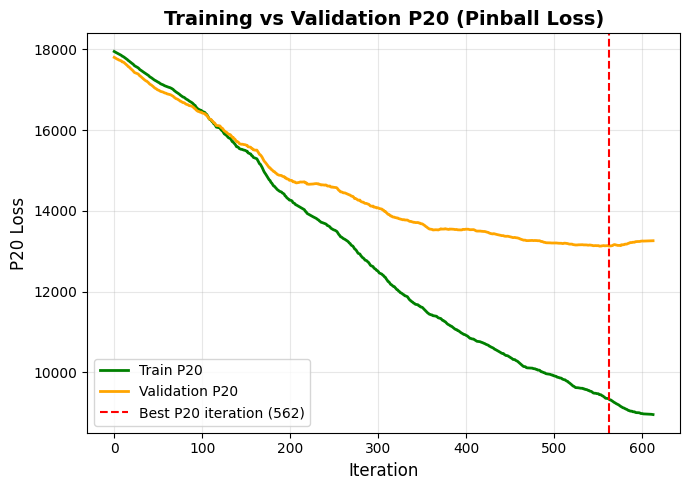


✓ Training curves saved to: overfitting_analysis.png

OVERFITTING ANALYSIS

📊 Final Metrics (P20):
   Training P20:   8,952.4678
   Validation P20: 13,258.7881
   Gap: 4,306.3203 (48.1%)

📈 Best Validation Performance (P20):
   Best P20 iteration: 562
   Best val P20: 13,125.6445
   Train P20 at best: 9,332.4326

🔍 Diagnosis (based on P20):
   ❌ OVERFITTING - Large train/val gap (48.1%)
     Model memorizing training data!

   Validation improvement: 26.3%
   (from iteration 0 to best iteration)


In [ ]:
print("=" * 70)
print("OVERFITTING ANALYSIS - TRAINING CURVES")
print("=" * 70)

# ============================================================================
# 1. EXTRACT TRAINING HISTORY FROM XGBOOST
# ============================================================================

print("\nAvailable metrics:")
for dataset, metrics in evals_result.items():
    print(f"  {dataset}: {list(metrics.keys())}")

# ============================================================================
# 2. PLOT TRAINING VS VALIDATION CURVES (INCLUDING P20)
# ============================================================================

# Determine number of subplots based on available metrics
n_plots = 0
has_mae = "mae" in evals_result.get("train", {}) and "mae" in evals_result.get(
    "val", {}
)
has_rmse = "rmse" in evals_result.get("train", {}) and "rmse" in evals_result.get(
    "val", {}
)
has_p20 = "p20" in evals_result.get("train", {}) and "p20" in evals_result.get(
    "val", {}
)

if has_mae:
    n_plots += 1
if has_rmse:
    n_plots += 1
if has_p20:
    n_plots += 1

if n_plots == 0:
    print("\n⚠️  No metrics available for plotting!")
else:
    fig, axes = plt.subplots(1, n_plots, figsize=(7 * n_plots, 5))
    if n_plots == 1:
        axes = [axes]  # Make it a list for consistent indexing

    plot_idx = 0

    # Plot 1: MAE over iterations
    if has_mae:
        train_mae = evals_result["train"]["mae"]
        val_mae = evals_result["val"]["mae"]
        iterations = range(len(train_mae))

        axes[plot_idx].plot(iterations, train_mae, label="Train MAE", linewidth=2)
        axes[plot_idx].plot(iterations, val_mae, label="Validation MAE", linewidth=2)

        # Mark best iteration
        best_iter = model.best_iteration
        if best_iter < len(train_mae):
            axes[plot_idx].axvline(
                best_iter,
                color="red",
                linestyle="--",
                label=f"Best iteration ({best_iter})",
            )

        axes[plot_idx].set_xlabel("Iteration", fontsize=12)
        axes[plot_idx].set_ylabel("MAE (kg)", fontsize=12)
        axes[plot_idx].set_title(
            "Training vs Validation MAE", fontsize=14, fontweight="bold"
        )
        axes[plot_idx].legend(fontsize=10)
        axes[plot_idx].grid(True, alpha=0.3)
        plot_idx += 1

    # Plot 2: RMSE over iterations
    if has_rmse:
        train_rmse = evals_result["train"]["rmse"]
        val_rmse = evals_result["val"]["rmse"]
        iterations = range(len(train_rmse))

        axes[plot_idx].plot(iterations, train_rmse, label="Train RMSE", linewidth=2)
        axes[plot_idx].plot(iterations, val_rmse, label="Validation RMSE", linewidth=2)

        # Mark best iteration
        best_iter = model.best_iteration
        if best_iter < len(train_rmse):
            axes[plot_idx].axvline(
                best_iter,
                color="red",
                linestyle="--",
                label=f"Best iteration ({best_iter})",
            )

        axes[plot_idx].set_xlabel("Iteration", fontsize=12)
        axes[plot_idx].set_ylabel("RMSE (kg)", fontsize=12)
        axes[plot_idx].set_title(
            "Training vs Validation RMSE", fontsize=14, fontweight="bold"
        )
        axes[plot_idx].legend(fontsize=10)
        axes[plot_idx].grid(True, alpha=0.3)
        plot_idx += 1

    # Plot 3: P20 (Pinball Loss) over iterations
    if has_p20:
        train_p20 = evals_result["train"]["p20"]
        val_p20 = evals_result["val"]["p20"]
        iterations = range(len(train_p20))

        axes[plot_idx].plot(
            iterations, train_p20, label="Train P20", linewidth=2, color="green"
        )
        axes[plot_idx].plot(
            iterations, val_p20, label="Validation P20", linewidth=2, color="orange"
        )

        # Find best iteration for P20 (lowest validation P20)
        best_iter_p20 = np.argmin(val_p20)
        axes[plot_idx].axvline(
            best_iter_p20,
            color="red",
            linestyle="--",
            label=f"Best P20 iteration ({best_iter_p20})",
        )

        axes[plot_idx].set_xlabel("Iteration", fontsize=12)
        axes[plot_idx].set_ylabel("P20 Loss", fontsize=12)
        axes[plot_idx].set_title(
            "Training vs Validation P20 (Pinball Loss)", fontsize=14, fontweight="bold"
        )
        axes[plot_idx].legend(fontsize=10)
        axes[plot_idx].grid(True, alpha=0.3)
        plot_idx += 1

    plt.tight_layout()
    plt.savefig("overfitting_analysis.png", dpi=300, bbox_inches="tight")
    plt.show()

    print("\n✓ Training curves saved to: overfitting_analysis.png")

# ============================================================================
# 3. ANALYZE OVERFITTING
# ============================================================================

print("\n" + "=" * 70)
print("OVERFITTING ANALYSIS")
print("=" * 70)

if has_mae:
    final_train_mae = train_mae[-1]
    final_val_mae = val_mae[-1]
    best_iter = model.best_iteration
    best_val_mae = val_mae[min(best_iter, len(val_mae) - 1)]

    # Calculate gap between train and validation
    train_val_gap = final_val_mae - final_train_mae
    gap_percentage = (train_val_gap / final_train_mae) * 100

    print(f"\n📊 Final Metrics (MAE):")
    print(f"   Training MAE:   {final_train_mae:,.2f} kg")
    print(f"   Validation MAE: {final_val_mae:,.2f} kg")
    print(f"   Gap: {train_val_gap:,.2f} kg ({gap_percentage:.1f}%)")

    print(f"\n📈 Best Validation Performance (MAE):")
    print(f"   Best iteration: {best_iter}")
    print(f"   Best val MAE: {best_val_mae:,.2f} kg")
    if best_iter < len(train_mae):
        print(f"   Train MAE at best: {train_mae[best_iter]:,.2f} kg")

# P20 Analysis
if has_p20:
    final_train_p20 = train_p20[-1]
    final_val_p20 = val_p20[-1]
    best_iter_p20 = np.argmin(val_p20)
    best_val_p20 = val_p20[best_iter_p20]

    # Calculate gap between train and validation
    train_val_gap_p20 = final_val_p20 - final_train_p20
    gap_percentage_p20 = (
        (train_val_gap_p20 / final_train_p20) * 100 if final_train_p20 != 0 else 0
    )

    print(f"\n📊 Final Metrics (P20):")
    print(f"   Training P20:   {final_train_p20:,.4f}")
    print(f"   Validation P20: {final_val_p20:,.4f}")
    print(f"   Gap: {train_val_gap_p20:,.4f} ({gap_percentage_p20:.1f}%)")

    print(f"\n📈 Best Validation Performance (P20):")
    print(f"   Best P20 iteration: {best_iter_p20}")
    print(f"   Best val P20: {best_val_p20:,.4f}")
    print(f"   Train P20 at best: {train_p20[best_iter_p20]:,.4f}")

    # Determine if overfitting
    print(f"\n🔍 Diagnosis (based on P20):")
    if gap_percentage_p20 < 10:
        print(
            f"   ✓ NO OVERFITTING - Train/val gap is small ({gap_percentage_p20:.1f}%)"
        )
        print(f"     Model generalizes well!")
    elif gap_percentage_p20 < 30:
        print(f"   ⚠️  SLIGHT OVERFITTING - Train/val gap is {gap_percentage_p20:.1f}%")
        print(f"     Acceptable but could be improved")
    else:
        print(f"   ❌ OVERFITTING - Large train/val gap ({gap_percentage_p20:.1f}%)")
        print(f"     Model memorizing training data!")

    # Check if validation improved over time
    val_improvement_p20 = (val_p20[0] - best_val_p20) / val_p20[0] * 100
    print(f"\n   Validation improvement: {val_improvement_p20:.1f}%")
    print(f"   (from iteration 0 to best iteration)")

# Overall diagnosis based on MAE
if has_mae:
    print(f"\n🔍 Overall Diagnosis (based on MAE):")
    if gap_percentage < 10:
        print(f"   ✓ NO OVERFITTING - Train/val gap is small ({gap_percentage:.1f}%)")
        print(f"     Model generalizes well!")
    elif gap_percentage < 30:
        print(f"   ⚠️  SLIGHT OVERFITTING - Train/val gap is {gap_percentage:.1f}%")
        print(f"     Acceptable but could be improved")
    else:
        print(f"   ❌ OVERFITTING - Large train/val gap ({gap_percentage:.1f}%)")
        print(f"     Model memorizing training data!")

    # Check if validation improved over time
    val_improvement = (val_mae[0] - best_val_mae) / val_mae[0] * 100
    print(f"\n   Validation improvement: {val_improvement:.1f}%")
    print(f"   (from iteration 0 to best iteration)")

# ============================================================================
# 4. ADDITIONAL DIAGNOSTIC PLOTS
# ============================================================================

1. XGBoost Feature Importance Analysis...

📊 Top 10 Most Important Features:
    1. week_of_year        :     4436
    2. days_since_last     :     2275
    3. month               :     2154
    4. avg_past_3y_janmay  :     1703
    5. last_6mo_weight     :     1197
    6. last_3mo_weight     :     1012
    7. avg_delivery_delay  :      908
    8. last_year_total     :      862
    9. last_year_janmay    :      747
   10. delivery_delay_days :      741

2. Permutation Importance Analysis...
   Calculating permutation importance (this may take a moment)...

📊 Top 10 Permutation Importance:
    1. days_since_last     : 4794.3596
    2. last_3mo_weight     : 3062.9355
    3. month               : 2663.2338
    4. last_6mo_weight     : 2526.5641
    5. week_of_year        : 2409.0549
    6. avg_weight_to_quantity_ratio: 203.8906
    7. recent_3mo_total    : 140.9603
    8. closed_order_rate   :  60.5554
    9. last_year_total     :  48.3261
   10. recent_po_activity  :  43.2655


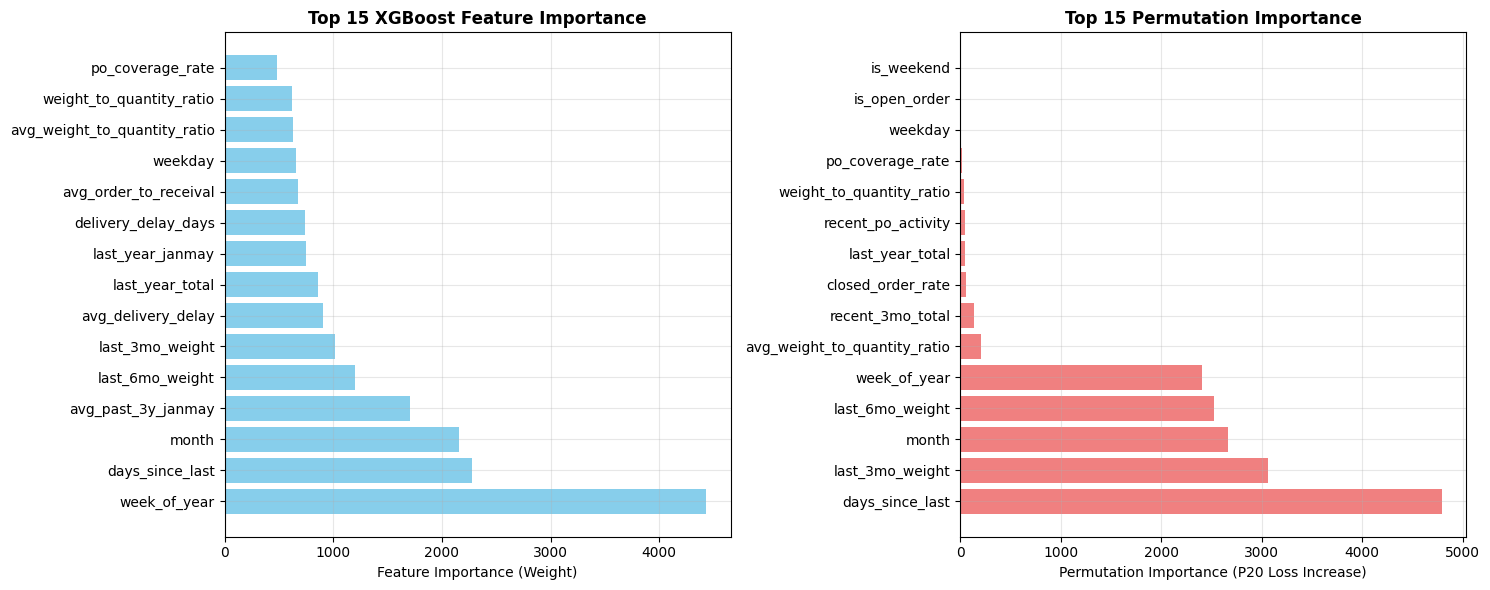

✓ Feature importance plots saved to: feature_importance_analysis.png


In [ ]:
# ============================================================================
# 1. XGBOOST FEATURE IMPORTANCE
# ============================================================================
print("1. XGBoost Feature Importance Analysis...")

# Get feature importance from XGBoost
feature_importance = model.get_score(importance_type="weight")
feature_names = [f for f in feature_importance.keys() if f != "rm_id"]
importance_values = [feature_importance[f] for f in feature_names]

# Sort by importance
sorted_features = sorted(
    zip(feature_names, importance_values), key=lambda x: x[1], reverse=True
)

print("\n📊 Top 10 Most Important Features:")
for i, (feature, importance) in enumerate(sorted_features[:10]):
    print(f"   {i + 1:2}. {feature:20}: {importance:8.0f}")

# ============================================================================
# 2. PERMUTATION IMPORTANCE (CUSTOM IMPLEMENTATION)
# ============================================================================
print("\n2. Permutation Importance Analysis...")


def custom_permutation_importance(model, X_val, y_val, n_repeats=5):
    """Custom permutation importance for XGBoost"""
    base_score = pinball_loss_p20(y_val, model.predict(xgb.DMatrix(X_val)))

    importance_scores = []
    feature_names = X_val.columns.tolist()

    for feature in feature_names:
        if feature == "rm_id":  # Skip rm_id
            importance_scores.append(0)
            continue

        feature_importance = []

        for _ in range(n_repeats):
            # Create shuffled copy
            X_shuffled = X_val.copy()
            X_shuffled[feature] = np.random.permutation(X_shuffled[feature])

            # Calculate score with shuffled feature
            shuffled_score = pinball_loss_p20(
                y_val, model.predict(xgb.DMatrix(X_shuffled))
            )
            feature_importance.append(shuffled_score - base_score)

        importance_scores.append(np.mean(feature_importance))

    return np.array(importance_scores), feature_names


# Calculate custom permutation importance
print("   Calculating permutation importance (this may take a moment)...")
perm_scores, perm_feature_names = custom_permutation_importance(
    model, X_val, y_val, n_repeats=3
)

# Sort by importance
perm_sorted = sorted(
    zip(perm_feature_names, perm_scores), key=lambda x: x[1], reverse=True
)

print("\n📊 Top 10 Permutation Importance:")
for i, (feature, importance) in enumerate(perm_sorted[:10]):
    print(f"   {i + 1:2}. {feature:20}: {importance:8.4f}")

# Plot permutation importance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot of top features (XGBoost importance)
top_features = [f[0] for f in sorted_features[:15]]
top_importance = [f[1] for f in sorted_features[:15]]

axes[0].barh(range(len(top_features)), top_importance, color="skyblue")
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features)
axes[0].set_xlabel("Feature Importance (Weight)")
axes[0].set_title("Top 15 XGBoost Feature Importance", fontweight="bold")
axes[0].grid(True, alpha=0.3)

# Bar plot of permutation importance
top_perm_features = [f[0] for f in perm_sorted[:15]]
top_perm_scores = [f[1] for f in perm_sorted[:15]]

axes[1].barh(range(len(top_perm_features)), top_perm_scores, color="lightcoral")
axes[1].set_yticks(range(len(top_perm_features)))
axes[1].set_yticklabels(top_perm_features)
axes[1].set_xlabel("Permutation Importance (P20 Loss Increase)")
axes[1].set_title("Top 15 Permutation Importance", fontweight="bold")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("feature_importance_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Feature importance plots saved to: feature_importance_analysis.png")

In [ ]:
# ============================================================================
# PARAMETER GRID SEARCH
# ============================================================================
print("\n" + "=" * 70)
print("PARAMETER GRID SEARCH")
print("=" * 70)

import itertools

# Define parameter grid
param_grid = {
    "max_depth": [4, 6, 8],
    "min_child_weight": [1, 3, 5],
    "eta": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "reg_alpha": [0, 0.1, 1.0],
    "reg_lambda": [1, 5, 10],
}

# Create all combinations
keys = param_grid.keys()
values = param_grid.values()
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Total parameter combinations: {len(param_combinations)}")
print("This might take a while...\n")

# Store results
grid_search_results = []

# Test a subset of combinations (for speed)
import random

random.seed(42)
sample_size = min(20, len(param_combinations))  # Test 20 random combinations
param_sample = random.sample(param_combinations, sample_size)

print(f"Testing {sample_size} random parameter combinations...")

for i, params in enumerate(param_sample):
    print(f"\n{'=' * 70}")
    print(f"Combination {i + 1}/{sample_size}")
    print(f"{'=' * 70}")
    print(f"Parameters: {params}")

    # Add fixed parameters
    full_params = {
        **params,
        "objective": "reg:quantileerror",
        "quantile_alpha": 0.20,
        "tree_method": "hist",
    }

    # Train model
    try:
        evals_result_temp = {}
        model_temp = xgb.train(
            full_params,
            dtrain,
            num_boost_round=500,  # Reduced for speed
            evals=[(dtrain, "train"), (dval, "val")],
            early_stopping_rounds=50,
            verbose_eval=False,
            evals_result=evals_result_temp,
            custom_metric=pinball_loss_p20_metric,
        )

        # Evaluate
        val_pred_temp = model_temp.predict(dval)
        val_p20_temp = pinball_loss_p20(y_val, val_pred_temp)

        # Store results
        grid_search_results.append(
            {
                "params": params,
                "val_p20": val_p20_temp,
                "best_iteration": model_temp.best_iteration,
            }
        )

        print(f"✓ Val P20 Loss: {val_p20_temp:,.2f} kg")
        print(f"  Best iteration: {model_temp.best_iteration}")

    except Exception as e:
        print(f"✗ Error: {e}")
        continue

# ============================================================================
# ANALYZE GRID SEARCH RESULTS
# ============================================================================
print("\n" + "=" * 70)
print("GRID SEARCH RESULTS")
print("=" * 70)

# Sort by validation P20 loss
grid_search_results.sort(key=lambda x: x["val_p20"])

# Display top 10 results
print("\n📊 Top 10 Parameter Combinations:")
for i, result in enumerate(grid_search_results[:10]):
    print(f"\n{i + 1}. Val P20 Loss: {result['val_p20']:,.2f} kg")
    print(f"   Parameters:")
    for key, value in result["params"].items():
        print(f"     {key}: {value}")
    print(f"   Best iteration: {result['best_iteration']}")

# Get best parameters
best_params = grid_search_results[0]["params"]
best_val_p20 = grid_search_results[0]["val_p20"]

print("\n" + "=" * 70)
print("🏆 BEST PARAMETERS FOUND")
print("=" * 70)
print(f"\nBest Val P20 Loss: {best_val_p20:,.2f} kg")
print("\nBest Parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# ============================================================================
# TRAIN FINAL MODEL WITH BEST PARAMETERS
# ============================================================================
print("\n" + "=" * 70)
print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
print("=" * 70)

# Combine best parameters with fixed parameters
final_params = {
    **best_params,
    "objective": "reg:quantileerror",
    "quantile_alpha": 0.20,
    "tree_method": "hist",
}

print("\nFinal parameters:")
for key, value in final_params.items():
    print(f"  {key}: {value}")

# Train final model
evals_result = {}
model = xgb.train(
    final_params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=50,
    verbose_eval=100,
    evals_result=evals_result,
    custom_metric=pinball_loss_p20_metric,
)

print(f"\n✓ Final model trained!")
print(f"  Best iteration: {model.best_iteration}")

# ============================================================================
# STEP 3: EVALUATE ON TRAIN AND VALIDATION
# ============================================================================
print("\n" + "=" * 70)
print("STEP 3: TRAIN vs VALIDATION PERFORMANCE")
print("=" * 70)

# Make predictions on BOTH train and validation
train_predictions = model.predict(dtrain)
val_predictions = model.predict(dval)

# Calculate metrics for TRAINING
train_mae = mean_absolute_error(y_train, train_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_p20_loss = pinball_loss_p20(y_train, train_predictions)

# Calculate metrics for VALIDATION
val_mae = mean_absolute_error(y_val, val_predictions)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
val_p20_loss = pinball_loss_p20(y_val, val_predictions)

# Display side-by-side comparison
print(f"\n📊 TRAINING Performance:")
print(f"   MAE:      {train_mae:,.2f} kg")
print(f"   RMSE:     {train_rmse:,.2f} kg")
print(f"   P20 Loss: {train_p20_loss:,.2f} kg")

print(f"\n📊 VALIDATION Performance:")
print(f"   MAE:      {val_mae:,.2f} kg")
print(f"   RMSE:     {val_rmse:,.2f} kg")
print(f"   P20 Loss: {val_p20_loss:,.2f} kg ⭐ (Competition Metric)")

# Calculate gaps
mae_gap = val_mae - train_mae
mae_gap_pct = (mae_gap / train_mae) * 100
rmse_gap = val_rmse - train_rmse
p20_gap = val_p20_loss - train_p20_loss
p20_gap_pct = (p20_gap / train_p20_loss) * 100

print(f"\n📈 TRAIN-VAL GAP (Overfitting Check):")
print(f"   MAE Gap:      {mae_gap:,.2f} kg ({mae_gap_pct:+.1f}%)")
print(f"   RMSE Gap:     {rmse_gap:,.2f} kg")
print(f"   P20 Gap:      {p20_gap:,.2f} kg ({p20_gap_pct:+.1f}%)")

# Overfitting diagnosis
print(f"\n🔍 Diagnosis:")
if p20_gap_pct < 10:
    print(f"   ✅ NO OVERFITTING - Gap is only {p20_gap_pct:.1f}%")
    print(f"      Model generalizes well!")
elif p20_gap_pct < 30:
    print(f"   ⚠️  SLIGHT OVERFITTING - Gap is {p20_gap_pct:.1f}%")
    print(f"      Acceptable but could be improved")
else:
    print(f"   ❌ SIGNIFICANT OVERFITTING - Gap is {p20_gap_pct:.1f}%")
    print(f"      Model memorizing training data!")

# Analyze prediction bias
train_under = (train_predictions < y_train).mean() * 100
train_over = (train_predictions > y_train).mean() * 100
val_under = (val_predictions < y_val).mean() * 100
val_over = (val_predictions > y_val).mean() * 100

print(f"\n📉 Prediction Bias:")
print(f"   TRAIN:")
print(f"      Under-predictions: {train_under:.1f}%")
print(f"      Over-predictions:  {train_over:.1f}%")
print(f"   VALIDATION:")
print(f"      Under-predictions: {val_under:.1f}%")
print(f"      Over-predictions:  {val_over:.1f}%")
print(f"   (p20 target: ~20% under-predictions)")

# Example predictions comparison
print(f"\n📋 Example Predictions (first 10 validation rows):")
comparison = pd.DataFrame(
    {
        "rm_id": val_unified["rm_id"].iloc[:10]
        if "val_unified" in locals()
        else val_df["rm_id"].iloc[:10],
        "date": (
            val_unified["target_date"].iloc[:10].dt.date
            if "val_unified" in locals()
            else val_df["target_date"].iloc[:10].dt.date
        ),
        "actual": y_val[:10],
        "predicted": val_predictions[:10],
        "error": val_predictions[:10] - y_val[:10],
    }
)
print(comparison.to_string(index=False))

# Clip negative predictions
val_predictions = np.maximum(val_predictions, 0)

# Continue with rest of the training code (monotonicity, test predictions, etc.)
# ============================================================================
# STEP 4: ENFORCE MONOTONICITY
# ============================================================================
print("\n" + "=" * 70)
print("STEP 4: ENFORCE MONOTONICITY")
print("=" * 70)

val_check = val_df[["rm_id", "target_date"]].copy()
val_check["predicted"] = val_predictions

# Enforce monotonicity
for rm_id in val_check["rm_id"].unique():
    mask = val_check["rm_id"] == rm_id
    val_check.loc[mask, "predicted"] = (
        val_check.loc[mask].sort_values("target_date")["predicted"].cummax().values
    )

val_predictions = val_check["predicted"].values
print("✓ Monotonicity enforced")

# Recalculate p20 after monotonicity fix
p20_loss_fixed = pinball_loss_p20(y_val, val_predictions)
print(f"  P20 Loss (before fix): {val_p20_loss:,.2f} kg")
print(f"  P20 Loss (after fix):  {p20_loss_fixed:,.2f} kg")

# ============================================================================
# STEP 5: PREDICT TEST DATA
# ============================================================================
print("\n" + "=" * 70)
print("STEP 5: PREDICT ON TEST DATA (2025)")
print("=" * 70)

dtest = xgb.DMatrix(X_test)
test_predictions = model.predict(dtest)

# Clip negatives
test_predictions = np.maximum(test_predictions, 0)

# Enforce monotonicity
test_df_pred = test_df[["ID", "rm_id", "target_date"]].copy()
test_df_pred["predicted_weight"] = test_predictions

for rm_id in test_df_pred["rm_id"].unique():
    mask = test_df_pred["rm_id"] == rm_id
    test_df_pred.loc[mask, "predicted_weight"] = (
        test_df_pred.loc[mask]
        .sort_values("target_date")["predicted_weight"]
        .cummax()
        .values
    )

print("✓ Test predictions made with monotonicity enforced")

print(f"\n📊 Test Prediction Statistics:")
print(f"  Min:    {test_df_pred['predicted_weight'].min():,.2f} kg")
print(f"  Max:    {test_df_pred['predicted_weight'].max():,.2f} kg")
print(f"  Mean:   {test_df_pred['predicted_weight'].mean():,.2f} kg")
print(f"  Median: {test_df_pred['predicted_weight'].median():,.2f} kg")

# ============================================================================
# STEP 6: CREATE SUBMISSION
# ============================================================================
print("\n" + "=" * 70)
print("STEP 6: CREATE SUBMISSION FILE")
print("=" * 70)

submission = pd.DataFrame(
    {"ID": test_df_pred["ID"], "predicted_weight": test_df_pred["predicted_weight"]}
)

submission = submission.sort_values("ID").reset_index(drop=True)

submission_file = "submission_p20_gridsearch_optimized.csv"
submission.to_csv(submission_file, index=False)

print(f"\n✓ Submission saved to: {submission_file}")
print(f"  Rows: {len(submission):,}")
print(f"\n📋 First 10 rows:")
print(submission.head(10).to_string(index=False))

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 70)
print("✅ GRID SEARCH OPTIMIZED MODEL COMPLETE!")
print("=" * 70)
print(f"""
Summary:
  ✓ Grid search tested {len(param_sample)} parameter combinations
  ✓ Best parameters found and applied
  ✓ Model trained with p20 quantile regression (20th percentile)
  ✓ Trained on {len(X_train):,} examples (2021-2023)
  ✓ Validated on {len(X_val):,} examples (2024)
  ✓ Predictions made for {len(X_test):,} examples (2025)
  ✓ Monotonicity enforced
  
Performance:
  TRAINING:
    MAE:  {train_mae:,.2f} kg
    P20:  {train_p20_loss:,.2f} kg
  
  VALIDATION:
    MAE:  {val_mae:,.2f} kg
    P20:  {p20_loss_fixed:,.2f} kg ⭐
  
  Overfitting Gap: {p20_gap_pct:.1f}% {"✅" if p20_gap_pct < 10 else "⚠️" if p20_gap_pct < 30 else "❌"}
  
Best Parameters Found:
  max_depth: {best_params.get("max_depth", "N/A")}
  min_child_weight: {best_params.get("min_child_weight", "N/A")}
  eta: {best_params.get("eta", "N/A")}
  subsample: {best_params.get("subsample", "N/A")}
  colsample_bytree: {best_params.get("colsample_bytree", "N/A")}
  reg_alpha: {best_params.get("reg_alpha", "N/A")}
  reg_lambda: {best_params.get("reg_lambda", "N/A")}
  
What p20 means:
  - Predicts the 20th percentile (conservative estimate)
  - Aims to under-predict only ~20% of the time
  - Good for inventory management (avoid stockouts)
  
Submission file: {submission_file}
""")

# ============================================================================
# ADDITIONAL ANALYSIS: FEATURE IMPORTANCE
# ============================================================================
print("\n" + "=" * 70)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# Get feature importance from the best model
feature_importance = model.get_score(importance_type="weight")
feature_names = [f for f in feature_importance.keys() if f != "rm_id"]
importance_values = [feature_importance[f] for f in feature_names]

# Sort by importance
sorted_features = sorted(
    zip(feature_names, importance_values), key=lambda x: x[1], reverse=True
)

print("\n📊 Top 15 Most Important Features:")
for i, (feature, importance) in enumerate(sorted_features[:15]):
    print(f"   {i + 1:2}. {feature:25}: {importance:8.0f}")

# ============================================================================
# SAVE MODEL AND RESULTS
# ============================================================================
print("\n" + "=" * 70)
print("SAVING MODEL AND RESULTS")
print("=" * 70)

# Save the model
model_file = "xgb_model_p20_gridsearch.pkl"
import pickle

with open(model_file, "wb") as f:
    pickle.dump(model, f)

# Save grid search results
results_file = "grid_search_results.csv"
results_df = pd.DataFrame(grid_search_results)
results_df.to_csv(results_file, index=False)

print(f"✓ Model saved to: {model_file}")
print(f"✓ Grid search results saved to: {results_file}")
print(f"✓ Submission file: {submission_file}")

print(f"\n🎯 Ready for submission!")
print(f"   Submit file: {submission_file}")
print(f"   Model file: {model_file}")
print(f"   Results file: {results_file}")


PARAMETER GRID SEARCH
Total parameter combinations: 2187
This might take a while...

Testing 20 random parameter combinations...

Combination 1/20
Parameters: {'max_depth': 4, 'min_child_weight': 3, 'eta': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.9, 'reg_alpha': 1.0, 'reg_lambda': 1}
✓ Val P20 Loss: 12,696.31 kg
  Best iteration: 92

Combination 2/20
Parameters: {'max_depth': 4, 'min_child_weight': 1, 'eta': 0.05, 'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 0.1, 'reg_lambda': 1}
✓ Val P20 Loss: 13,154.21 kg
  Best iteration: 142

Combination 3/20
Parameters: {'max_depth': 6, 'min_child_weight': 3, 'eta': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_alpha': 0, 'reg_lambda': 5}
✓ Val P20 Loss: 13,728.64 kg
  Best iteration: 78

Combination 4/20
Parameters: {'max_depth': 6, 'min_child_weight': 3, 'eta': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 5}
✓ Val P20 Loss: 13,660.44 kg
  Best iteration: 498

Combination 5/20
Parameter